In [19]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import sys
import numpy as np

In [20]:
# Config
models = ["GPT-o1", "Llama3-8B", "Qwen-14B"]
DATASETS = ["camperplus", "fish&chips", "grocery", "planningpoker", "recycling", "school", "sports", "supermarket", "ticket"]

# Determine project root
cwd = Path.cwd()

In [21]:
# Collect all data
def collect_data(experiment_type):
    df_all = pd.DataFrame({
        "Dataset": pd.Series(dtype="str"),
        "Model": pd.Series(dtype="str"),
        "Run": pd.Series(dtype="int"),
        f"F-0.5 Score": pd.Series(dtype="float"),
        f"F-1 Score": pd.Series(dtype="float"),
        f"F-2 Score": pd.Series(dtype="float"),
    })

    for model in models:
        for dataset in DATASETS:
            file_path = (
                Path("thesis-artifacts") / "Extracted_Data" /
                experiment_type / model / dataset / "evaluation_results.xlsx"
            )

            if file_path.exists():
                df2 = pd.read_excel(file_path, sheet_name="including optional")
                df2_tidy = pd.DataFrame({
                    "Dataset": dataset,
                    "Model": model,
                    "Run": range(1, len(df2) + 1),
                    "F-0.5 Score": df2["F-0.5"],
                    "F-1 Score": df2["F-1"],
                    "F-2 Score": df2["F-2"],
                })
                df_all = pd.concat([df_all, df2_tidy], ignore_index=True)
            else:
                print(f"⚠️ File not found: {file_path}")

    return df_all



# Class Boxplot - Performance across runs

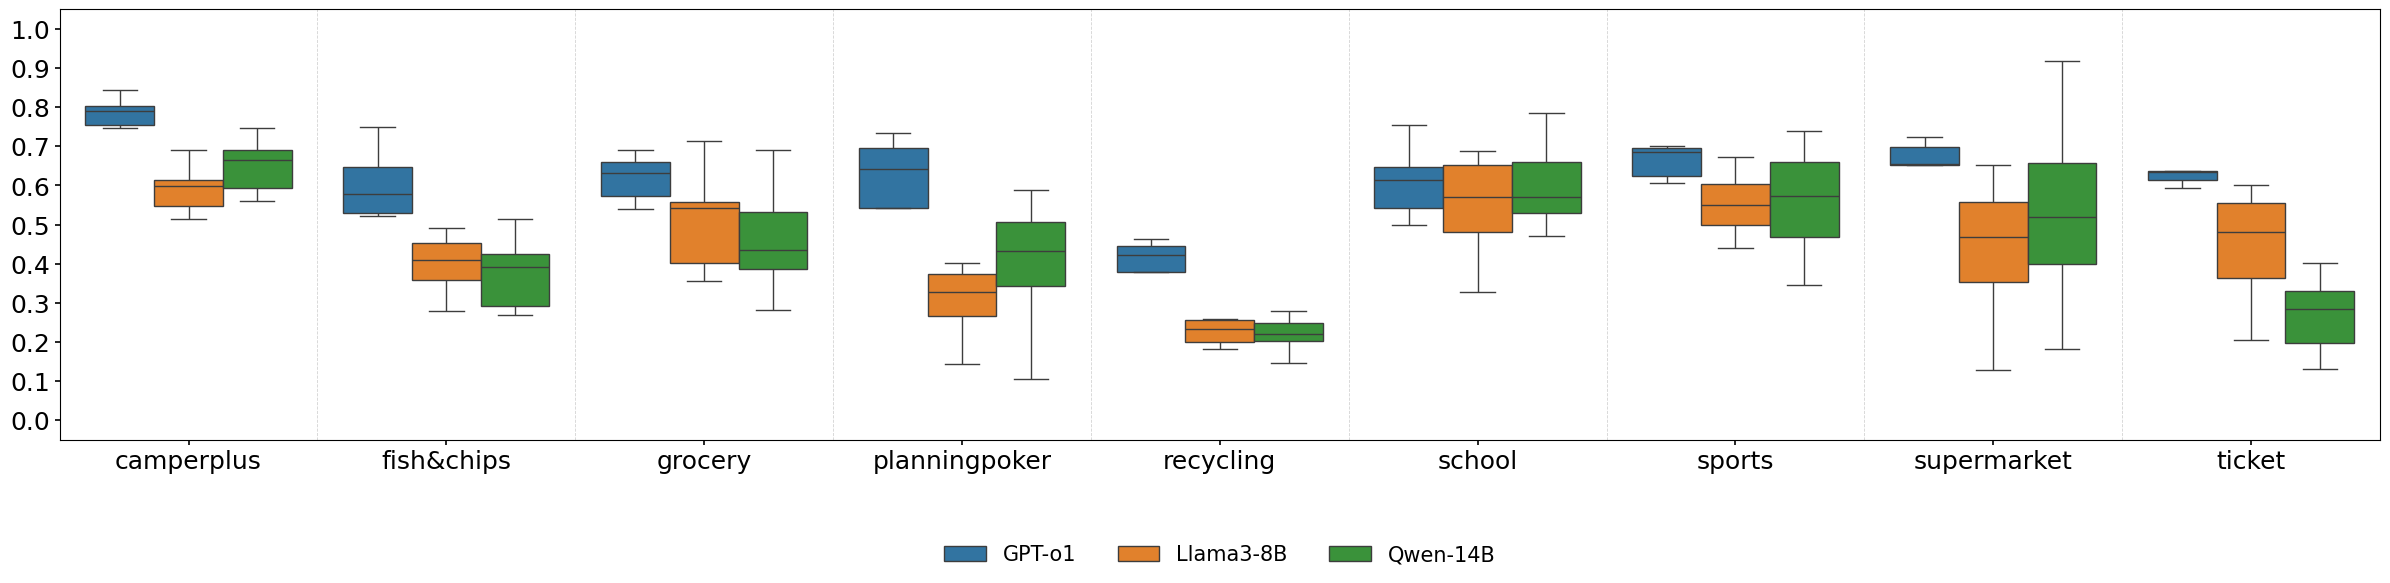

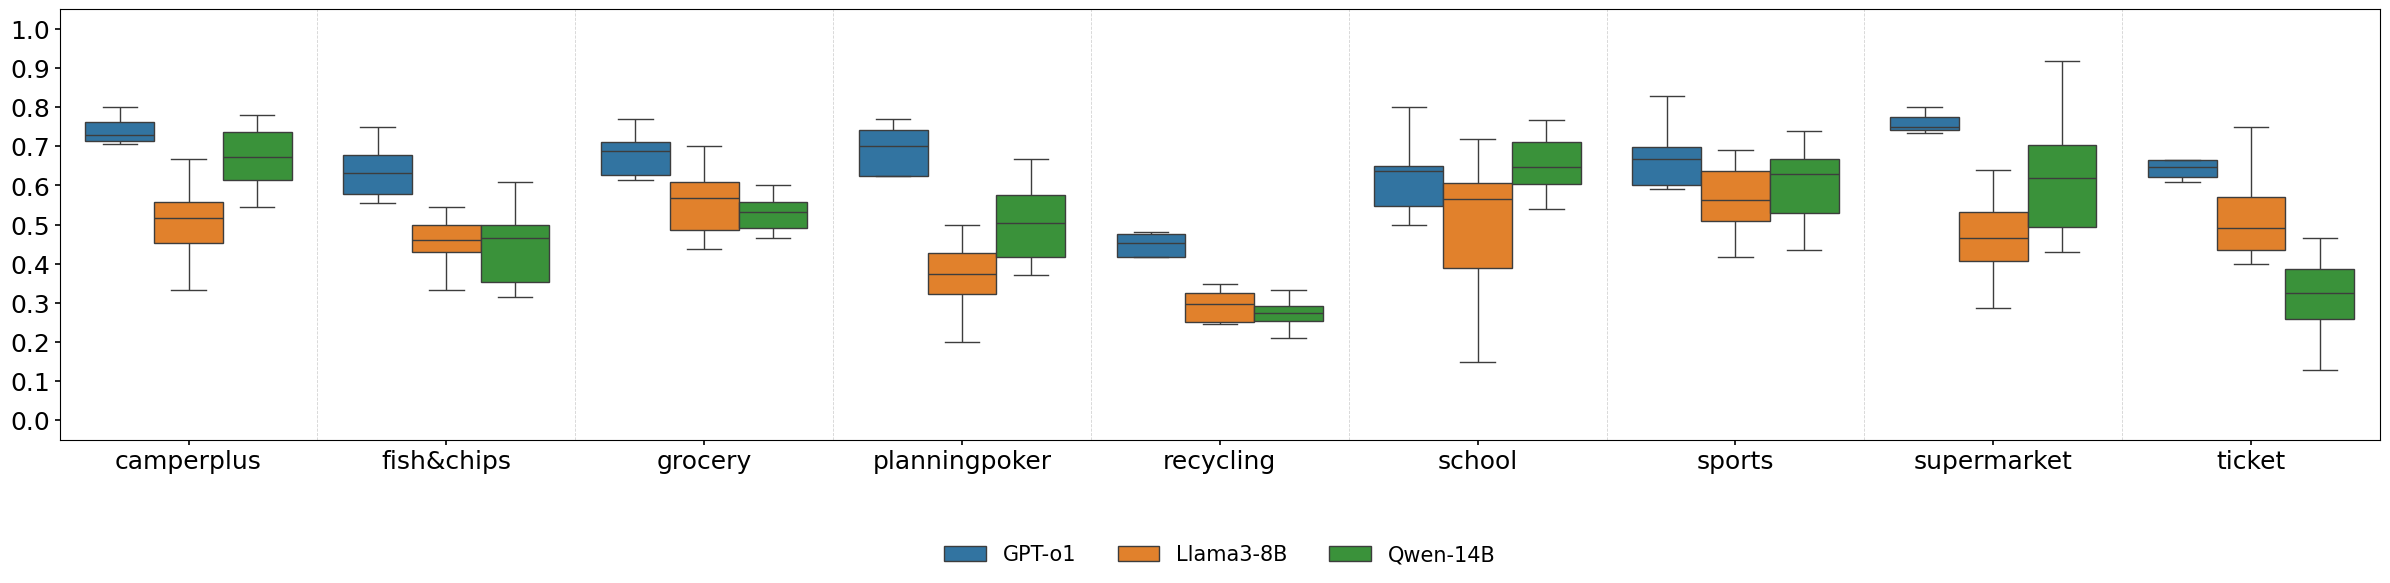

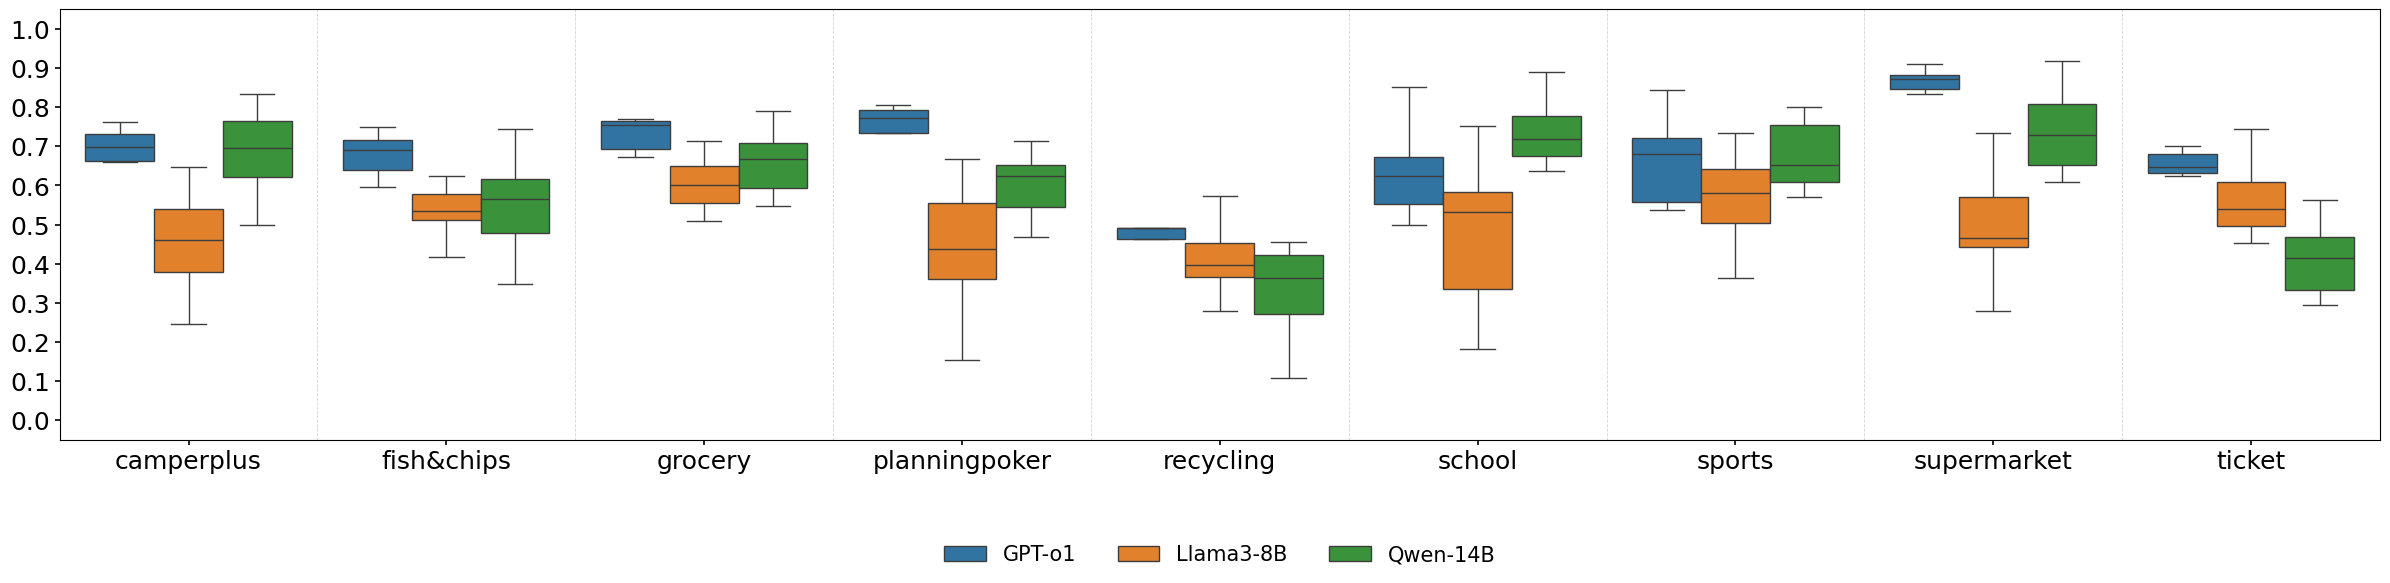

In [22]:
experiment_type = "class"
df_class = collect_data(experiment_type=experiment_type)

def style_plot(ax):
    ax.set_xlabel("")   
    ax.set_ylabel("")   
    
    ax.tick_params(axis='x', labelsize=18, width=1.2)
    ax.tick_params(axis='y', labelsize=18, width=1.2)

    ax.set_ylim(-0.05, 1.05)
    ax.set_yticks(np.arange(0.0, 1.1, 0.1))
    
    ax.legend(
        title=None,
        bbox_to_anchor=(0.5, -0.20),
        loc="upper center",
        ncol=3,
        fontsize=15,     
        frameon=False
    )

    plt.tight_layout()

def plot_box(df, y_col):
    plt.figure(figsize=(24, 6)) 
    ax = sns.boxplot(data=df, x="Dataset", y=y_col, hue="Model", showfliers=False)
    for i in range(1, len(ax.get_xticks())):
        ax.axvline(x=i - 0.5, color='lightgray', linestyle='--', linewidth=0.6)
    style_plot(ax)
    plt.show()

plot_box(df_class, "F-0.5 Score")
plot_box(df_class, "F-1 Score")
plot_box(df_class, "F-2 Score")


# Class Boxplot - Performance across models

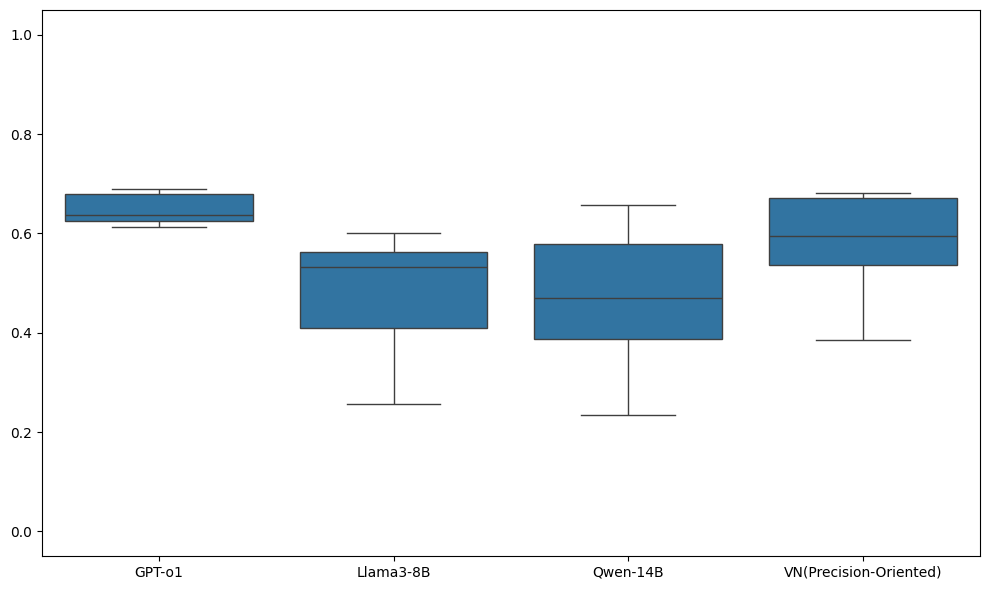

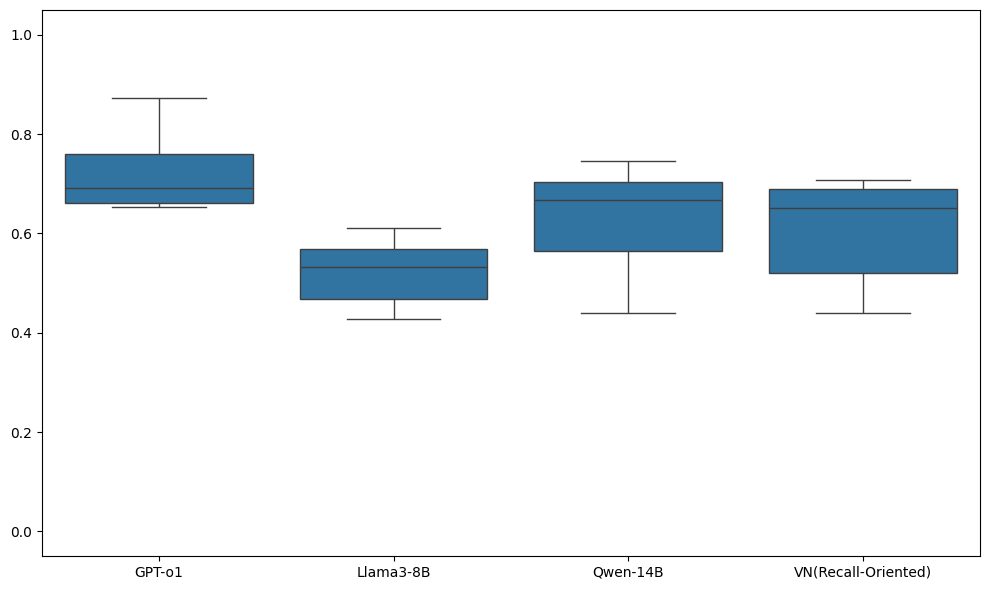

In [23]:
xlsx_path = Path("thesis-artifacts") / "Quantitative Analysis" / "class_evaluation.xlsx"
df_class = pd.read_excel(xlsx_path, sheet_name="class-Performance")

metrics_row = df_class.iloc[0].tolist()
orig_cols   = df_class.columns.tolist()

models_list = []
curr = None
for c in orig_cols:
    if c.startswith("Unnamed"):
        models_list.append(curr)
    else:
        curr = c
        models_list.append(c)

new_cols = []
for i, (m, met) in enumerate(zip(models_list, metrics_row)):
    if i == 0:
        new_cols.append("Dataset")
    else:
        new_cols.append(f"{m}_{met}")

df = df_class.iloc[1:].copy()
df.columns = new_cols
for c in df.columns[1:]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df = df[~df["Dataset"].isin(["AVG", "STD-DEV"])].reset_index(drop=True)

# Convert wide → long
long = df.melt(id_vars="Dataset", var_name="ModelMetric", value_name="Score")
long[["Model", "Metric"]] = long["ModelMetric"].str.rsplit("_", n=1, expand=True)

models_f05 = ["GPT-o1", "Llama3-8B", "Qwen-14B", "VN(Precision-Oriented)"]
f05 = long[(long["Metric"] == "F-0.5") & (long["Model"].isin(models_f05))]

plt.figure(figsize=(10, 6))
sns.boxplot(data=f05, x="Model", y="Score", order=models_f05, showfliers=False)
plt.ylabel("")
plt.xlabel("")
plt.ylim(-0.05, 1.05)
plt.tight_layout()
plt.show()


models_f2 = ["GPT-o1", "Llama3-8B", "Qwen-14B", "VN(Recall-Oriented)"]
f2 = long[(long["Metric"] == "F-2") & (long["Model"].isin(models_f2))]

plt.figure(figsize=(10, 6))
sns.boxplot(data=f2, x="Model", y="Score", order=models_f2, showfliers=False)
plt.ylabel("")
plt.xlabel("")
plt.ylim(-0.05, 1.05)
plt.tight_layout()
plt.show()


# Class FP-Analysis

In [31]:
def collect_fp_data_percentage(experiment_type):

    if experiment_type.lower() == "association":
        model_map = {
            "count_GPT-o1": "GPT-o1",
            "count_Llama3-8B": "Llama3-8B",
            "count_Qwen-14B": "Qwen-14B"
        }
    else:
        model_map = {
            "count_GPT-o1": "GPT-o1",
            "count_Llama3-8B": "Llama3-8B",
            "count_Qwen-14B": "Qwen-14B",
            "count_VN_Precision-Oriented": "VN-Precision",
            "count_VN_Recall-Oriented": "VN-Recall"
        }

    df_all = pd.DataFrame({
        "Dataset": pd.Series(dtype="str"),
        "Model": pd.Series(dtype="str"),
        "Type": pd.Series(dtype="str"),
        "Percentage": pd.Series(dtype="float"),
        "Count": pd.Series(dtype="int"),
        "Total": pd.Series(dtype="int")
    })  
    for dataset in DATASETS:
        fp_file_path = Path("thesis-artifacts") / "Qualitative Analysis" / f"{experiment_type}" / f"{dataset}_fp_analysis.xlsx"
        
        if not fp_file_path.exists():
            print(f"⚠️ File not found: {fp_file_path}")
            continue

        df = pd.read_excel(fp_file_path, sheet_name="Individual Result")
        all_types = df["type"].dropna().unique()
        summary_df = pd.DataFrame(index=all_types)

        for col, model_name in model_map.items():
            # print(col, model_name)
            counts = df.groupby("type")[col].apply(lambda x: x.notna().sum())
            summary_df[model_name] = counts
        summary_df = summary_df.fillna(0).astype(int).sort_index().reset_index()
        summary_df = summary_df.rename(columns={"index": "Type"})

        for model in summary_df.columns[1:]:
            model_counts = summary_df[model]
            total_count = model_counts.sum()

            if total_count == 0:
                percentages = [0] * len(model_counts)
            else:
                percentages = (model_counts / total_count).round(2)

            df_tidy = pd.DataFrame({
                "Dataset": dataset,
                "Model": model,
                "Type": summary_df["Type"],
                "Count": model_counts,
                "Percentage": percentages,
                "Total": total_count
            })
            df_all = pd.concat([df_all, df_tidy], ignore_index=True)

    return df_all


In [32]:
def collect_fp_data(experiment_type):
    
    if experiment_type.lower() == "association":
        model_map = {
            "count_GPT-o1": "GPT-o1",
            "count_Llama3-8B": "Llama3-8B",
            "count_Qwen-14B": "Qwen-14B"
        }
    else:
        model_map = {
            "count_GPT-o1": "GPT-o1",
            "count_Llama3-8B": "Llama3-8B",
            "count_Qwen-14B": "Qwen-14B",
            "count_VN_Precision-Oriented": "VN-Precision",
            "count_VN_Recall-Oriented": "VN-Recall"
        }

    df_all = pd.DataFrame({
        "Dataset": pd.Series(dtype="str"),
        "Model": pd.Series(dtype="str"),
        "Type": pd.Series(dtype="str"),
        "Count": pd.Series(dtype="int"),
    })  

    for dataset in DATASETS:
        fp_file_path = Path("thesis-artifacts") / "Qualitative Analysis" / f"{experiment_type}" / f"{dataset}_fp_analysis.xlsx"
        
        if not fp_file_path.exists():
            print(f"⚠️ File not found: {fp_file_path}")
            continue

        df = pd.read_excel(fp_file_path, sheet_name="Individual Result")
        all_types = df["type"].dropna().unique()
        summary_df = pd.DataFrame(index=all_types)

        for col, model_name in model_map.items():
            counts = df.groupby("type")[col].apply(lambda x: x.notna().sum())
            summary_df[model_name] = counts

        summary_df = summary_df.fillna(0).astype(int).sort_index().reset_index()

        for model in summary_df.columns[1:]:
            df_tidy = pd.DataFrame({
                "Dataset": dataset,
                "Model": model,
                "Type": summary_df["index"],
                "Count": summary_df[model],
            })
            df_all = pd.concat([df_all, df_tidy])
        df_all = df_all.reset_index(drop=True)
    return df_all


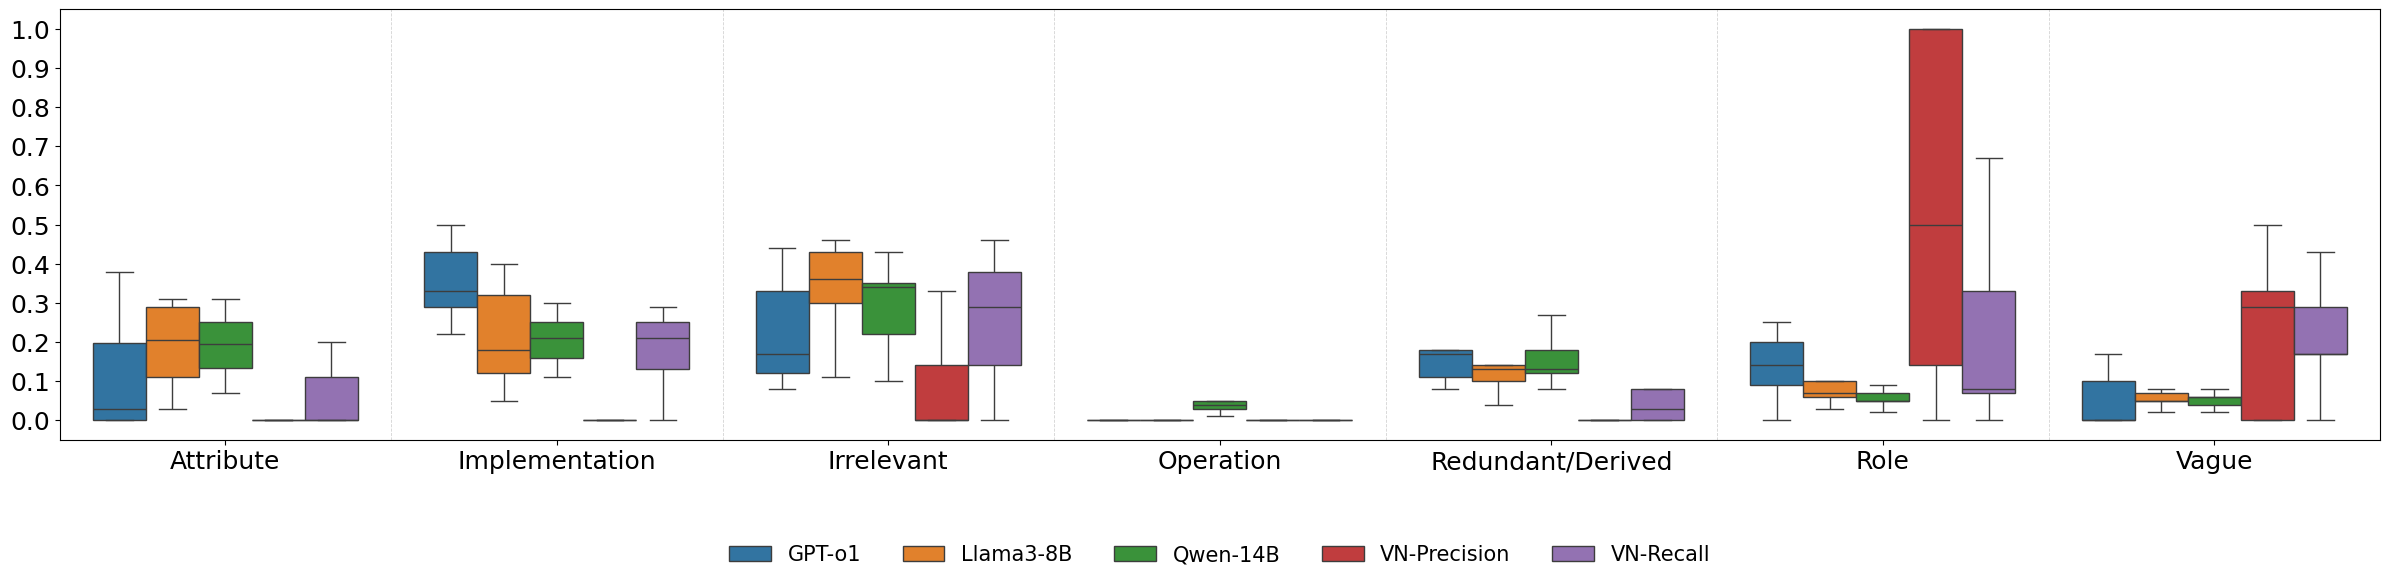

In [33]:
experiment_type = "class"
df_class_fp = collect_fp_data_percentage(experiment_type)

plt.figure(figsize=(24, 6)) 
ax = sns.boxplot(
    data=df_class_fp,
    x="Type",
    y="Percentage",
    hue="Model",
    showfliers=False            
)

for i in range(1, len(ax.get_xticks())):
    ax.axvline(x=i - 0.5, color='lightgray', linestyle='--', linewidth=0.6)

ax.set_xlabel("")               
ax.set_ylabel("")              
ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)


ax.set_ylim(-0.05, 1.05)
ax.set_yticks(np.arange(0.0, 1.1, 0.1))

ax.legend(
    title=None,
    bbox_to_anchor=(0.5, -0.20),
    loc="upper center",
    ncol=5,
    fontsize=15,
    frameon=False
)

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


# Association Boxplot - Performance across runs

In [ ]:
experiment_type = "association"
df_association = collect_data(experiment_type=experiment_type)

def style_plot(ax):
    ax.set_xlabel("")   
    ax.set_ylabel("")  
    
    ax.tick_params(axis='x', labelsize=18, width=1.2)
    ax.tick_params(axis='y', labelsize=18, width=1.2)
    
    ax.set_ylim(-0.05, 1.05)
    ax.set_yticks(np.arange(0.0, 1.1, 0.1))

    ax.legend(
        title=None,
        bbox_to_anchor=(0.5, -0.20),
        loc="upper center",
        ncol=3,
        fontsize=15,
        frameon=False
    )
    plt.tight_layout()


def plot_box(df, y_col):
    plt.figure(figsize=(24, 6)) 
    ax = sns.boxplot(data=df, x="Dataset", y=y_col, hue="Model", showfliers=False)
    for i in range(1, len(ax.get_xticks())):
        ax.axvline(x=i - 0.5, color='lightgray', linestyle='--', linewidth=0.6)
    style_plot(ax)
    plt.show()


plot_box(df_association, "F-0.5 Score")
plot_box(df_association, "F-1 Score")
plot_box(df_association, "F-2 Score")

# Association Boxplot - Performance across models

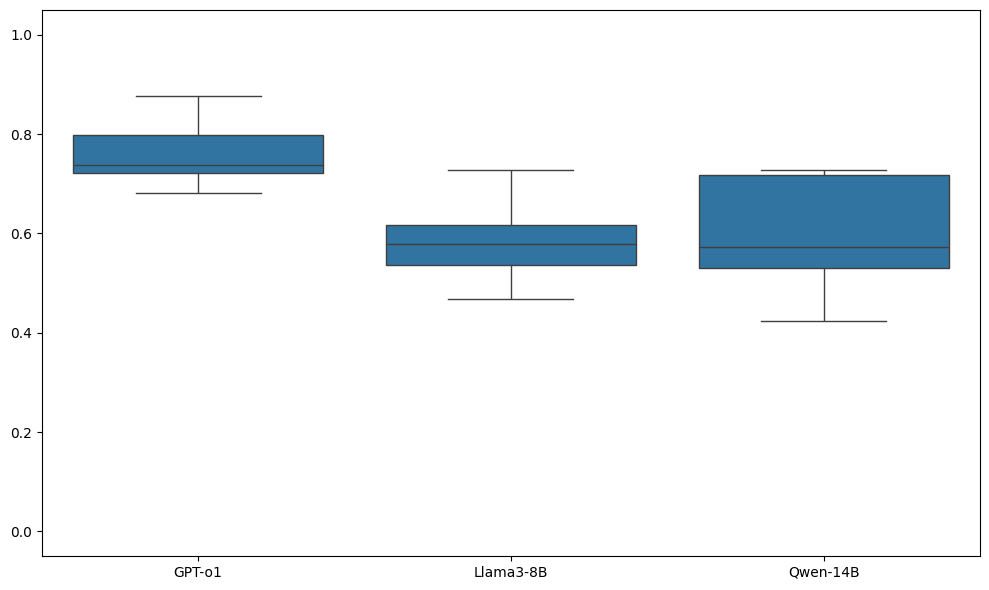

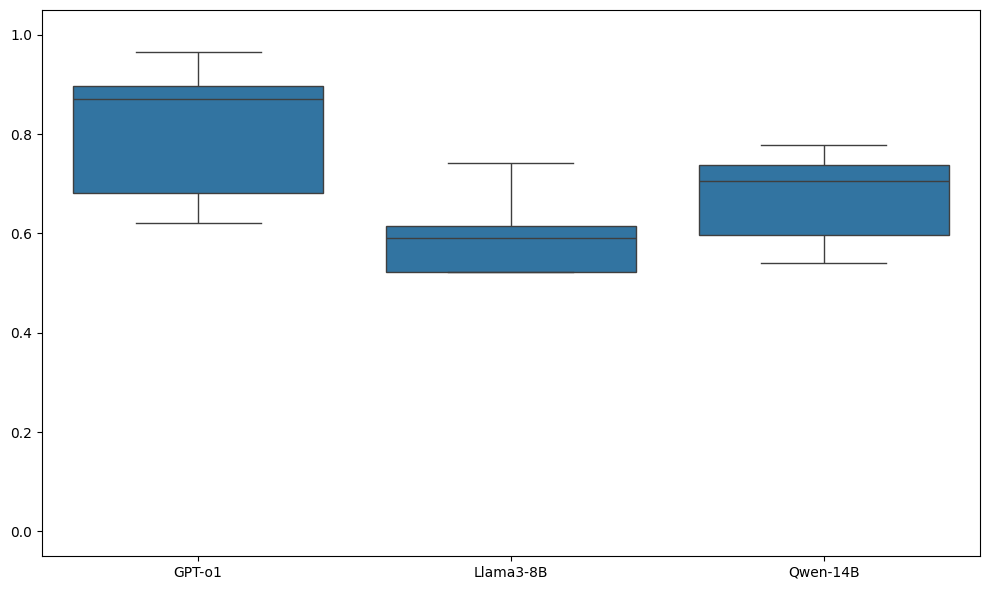

In [34]:
xlsx_path = Path("thesis-artifacts") / "Quantitative Analysis" / "association_evaluation.xlsx"
df_class = pd.read_excel(xlsx_path, sheet_name="association-Performance")

metrics_row = df_class.iloc[0].tolist()
orig_cols   = df_class.columns.tolist()

models_list = []
curr = None
for c in orig_cols:
    if c.startswith("Unnamed"):
        models_list.append(curr)
    else:
        curr = c
        models_list.append(c)

new_cols = []
for i, (m, met) in enumerate(zip(models_list, metrics_row)):
    if i == 0:
        new_cols.append("Dataset")
    else:
        new_cols.append(f"{m}_{met}")

df = df_class.iloc[1:].copy()
df.columns = new_cols
for c in df.columns[1:]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df = df[~df["Dataset"].isin(["AVG", "STD-DEV"])].reset_index(drop=True)

# Convert wide → long
long = df.melt(id_vars="Dataset", var_name="ModelMetric", value_name="Score")
long[["Model", "Metric"]] = long["ModelMetric"].str.rsplit("_", n=1, expand=True)

models_f05 = ["GPT-o1", "Llama3-8B", "Qwen-14B"]
f05 = long[(long["Metric"] == "F-0.5") & (long["Model"].isin(models_f05))]
plt.figure(figsize=(10, 6))
sns.boxplot(data=f05, x="Model", y="Score", order=models_f05, showfliers=False)
plt.ylabel("")
plt.xlabel("")
plt.ylim(-0.05, 1.05)
plt.tight_layout()
plt.show()


models_f2 = ["GPT-o1", "Llama3-8B", "Qwen-14B"]
f2 = long[(long["Metric"] == "F-2") & (long["Model"].isin(models_f2))]

plt.figure(figsize=(10, 6))
sns.boxplot(data=f2, x="Model", y="Score", order=models_f2, showfliers=False)
plt.ylabel("")
plt.xlabel("")
plt.ylim(-0.05, 1.05)
plt.tight_layout()
plt.show()


# Association FP Analysis

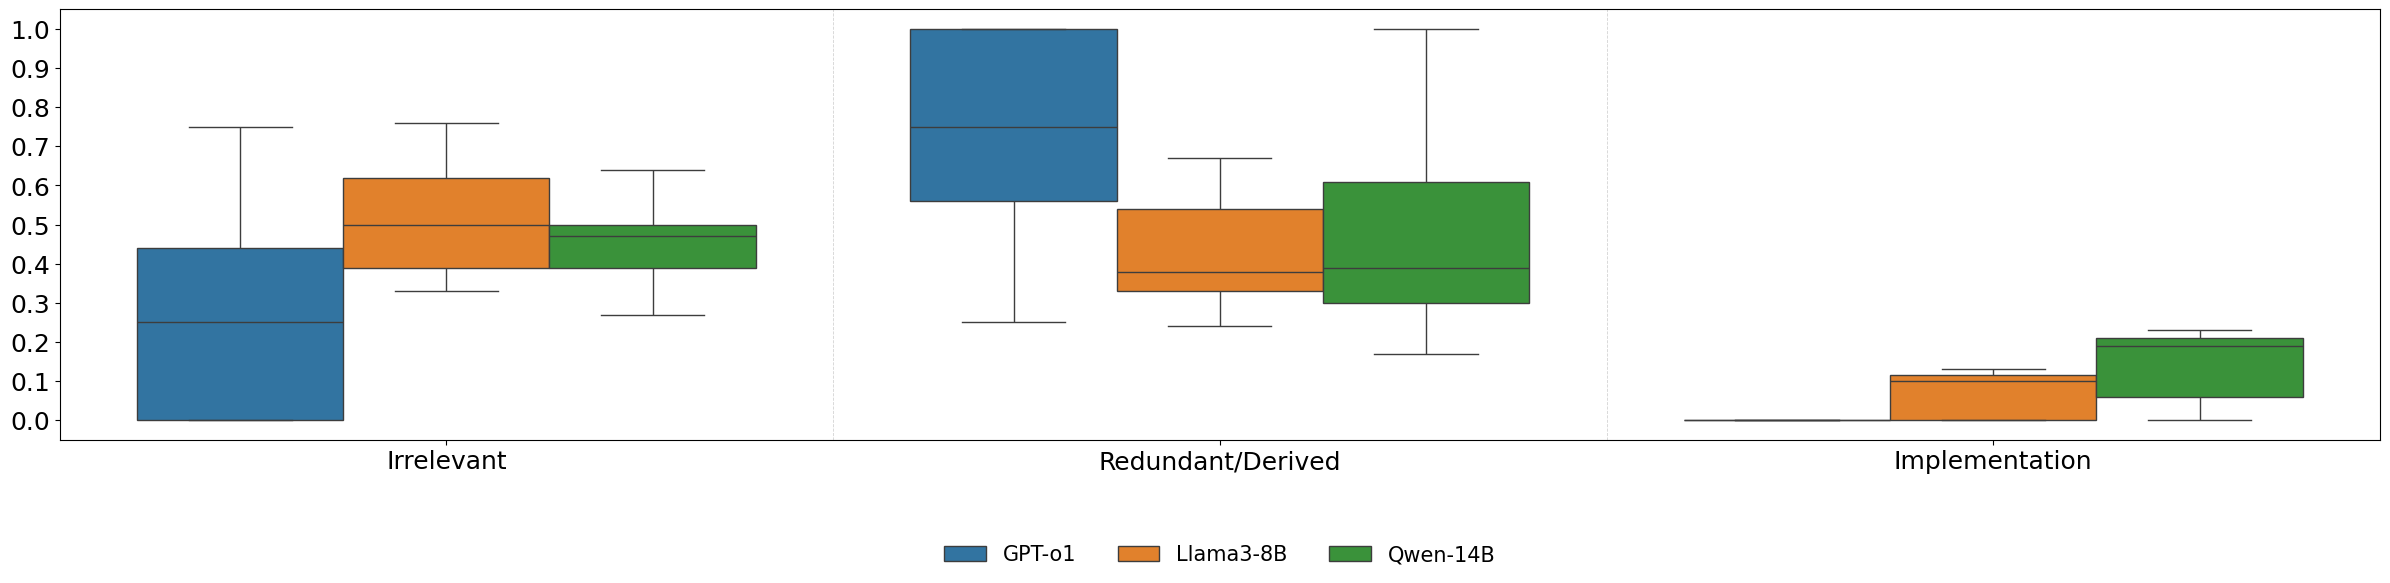

In [35]:
experiment_type = "association"
df_assoc_fp = collect_fp_data_percentage(experiment_type)

plt.figure(figsize=(24, 6))
ax = sns.boxplot(
    data=df_assoc_fp,
    x="Type",
    y="Percentage",
    hue="Model",
    showfliers=False  
)

for i in range(1, len(ax.get_xticks())):
    ax.axvline(x=i - 0.5, color='lightgray', linestyle='--', linewidth=0.6)
ax.set_xlabel("")
ax.set_ylabel("")

ax.tick_params(axis='x', labelsize=18)
ax.tick_params(axis='y', labelsize=18)

ax.set_ylim(-0.05, 1.05)
ax.set_yticks(np.arange(0.0, 1.1, 0.1))

ax.legend(
    title=None,
    bbox_to_anchor=(0.5, -0.20),
    loc="upper center",
    ncol=5,
    fontsize=15,
    frameon=False
)

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
